In [97]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math

sector_size = 9
idx = 5


In [98]:
def convertHSV(img):
    return matplotlib.colors.rgb_to_hsv(img[:,:,:3])

def convertRGB(img):
    return matplotlib.colors.hsv_to_rgb(img)

def normalize(img):
    imgMin = np.min(img)
    imgMax = np.max(img)
    return (img-imgMin)/(imgMax-imgMin)

def normalizedV(img):
    return normalize(img[:,:,2])

def applyFFT(img):
    imgFFT = np.fft.fft2(img)
    return imgFFT

def applyIFFT(img):
    imgIFFT = np.fft.ifft2(img)
    return imgIFFT

def encode(img1, img2):
    imgBase = applyFFT(img1)
    height, width = imgBase.shape
    
    imgSecret = applyFFT(img2)
    imgSecretFlat = imgSecret.ravel()
    ind = 0
    
    if((height*width)/sector_size**2 < len(imgSecretFlat)):
        print('Encoding not possible')
    
    for x in range (0, height-idx, sector_size):
        for y in range (0, width-idx, sector_size):
            if ind < len(imgSecretFlat):
                imgBase[x+idx, y+idx] = imgSecretFlat[ind]
                #print(ind,x+idx,y+idx)
                ind += 1
            else:
                break
    
    return abs(applyIFFT(imgBase))

def decode(img1,img2):
    imgBase = applyFFT(img1)
    height, width = imgBase.shape
    
    secret_h, secret_w = img2.shape
    secret = np.zeros((secret_h*secret_w), dtype=np.complex128)
    ind = 0
    for x in range (0, height-idx, sector_size):
        for y in range (0, width-idx, sector_size):
            if ind < len(secret):
                secret[ind] = imgBase[x+idx, y+idx]
                #print(ind,x+idx,y+idx)
                ind += 1
            else:
                break
    secret = secret.reshape((secret_h,secret_w))
    return abs(applyIFFT(secret))
    

In [99]:
imgBaseName = './images/input.jpg'
imgSecretName = './images/qr.png'

imgBase = plt.imread(imgBaseName)

imgBaseHSV = convertHSV(imgBase)
imgBaseV = normalizedV(imgBaseHSV)
matplotlib.image.imsave('./images/pre.png', imgBaseV)

imgSecret = plt.imread(imgSecretName)
imgSecretHSV = convertHSV(imgSecret)
imgSecretV = normalizedV(imgSecretHSV)

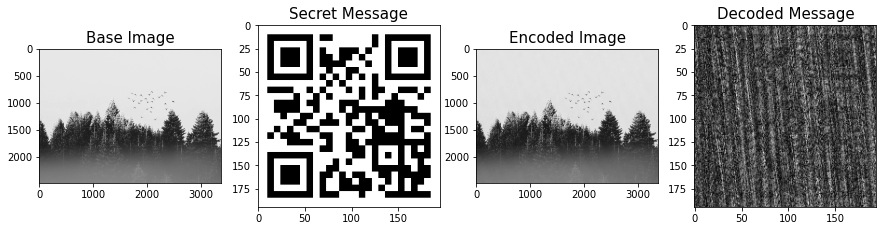

In [101]:
fig, ax = plt.subplots(1,4,figsize=(15,15))
ax[0].set_title('Base Image', fontsize = 15)
ax[0].imshow(imgBaseV, cmap='gray')

ax[1].set_title('Secret Message', fontsize = 15)
ax[1].imshow(imgSecretV, cmap='gray')

encodedImageV = encode(imgBaseV, imgSecretV)
encodedImage = imgBaseHSV
encodedImage[:,:,2] = encodedImageV*255

noise = encode(imgBaseV, np.zeros(imgSecretV.shape)+1)

finalImage = np.copy(imgBase)
finalImage[:,:,:3] = convertRGB(encodedImage)
matplotlib.image.imsave('./images/encoded.png', finalImage)
ax[2].set_title('Encoded Image', fontsize = 15)
ax[2].imshow(encodedImageV, cmap='gray')

encodedImage = convertHSV(finalImage)
encodedImageV = normalizedV(encodedImage)
secret = decode(encodedImageV,imgSecretV)
matplotlib.image.imsave('./images/decoded.png', secret)
ax[3].set_title('Decoded Message', fontsize = 15)
ax[3].imshow(normalize(secret), cmap='gray')

In [93]:
print(normalize(secret))

[[0.46212613 0.18206062 0.33929303 ... 0.19520324 0.40351873 0.52567894]
 [0.34291179 0.30141038 0.27928818 ... 0.16433882 0.69872275 0.40081123]
 [0.14116843 0.41526408 0.15639975 ... 0.21444559 0.67560783 0.42500732]
 ...
 [0.26141754 0.17770739 0.11397866 ... 0.43319165 0.52362404 0.57573222]
 [0.22651242 0.35192066 0.10132753 ... 0.30981974 0.43096241 0.40809029]
 [0.27375322 0.36193427 0.27470228 ... 0.2352767  0.43292835 0.59591146]]


[[223. 226. 230. ... 228. 229. 228.]
 [229. 228. 229. ... 229. 229. 228.]
 [234. 231. 230. ... 230. 231. 229.]
 ...
 [129. 128. 129. ... 105. 104. 103.]
 [128. 127. 128. ... 105. 105. 105.]
 [127. 127. 128. ... 105. 105. 105.]]


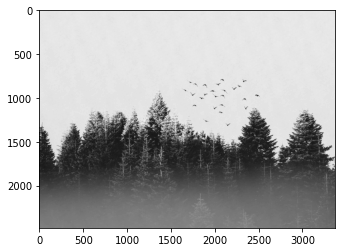

In [94]:
print(encodedImage[:,:,2])
plt.imshow(encodedImage[:,:,2], cmap='gray')

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


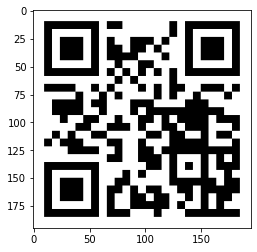

In [95]:
print(imgSecretV)
plt.imshow(imgSecretV, cmap='gray')

[[0.87916666 0.89166665 0.90416664 ... 0.9        0.90416664 0.90416664]
 [0.9        0.9        0.9        ... 0.9        0.9        0.9       ]
 [0.9166667  0.90833336 0.9        ... 0.9        0.9        0.9       ]
 ...
 [0.50416666 0.50416666 0.5083333  ... 0.41666666 0.4125     0.4125    ]
 [0.5        0.5        0.5        ... 0.42083332 0.41666666 0.41666666]
 [0.5        0.5        0.5        ... 0.42083332 0.41666666 0.41666666]]


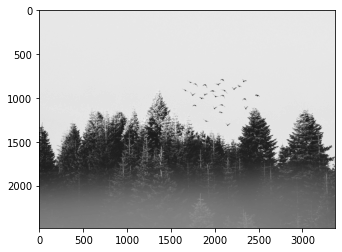

In [96]:
print(imgBaseV)
plt.imshow(imgBaseV, cmap='gray')

[[0.87672236 0.88940826 0.90532275 ... 0.89861477 0.90112394 0.90034426]
 [0.89880022 0.89844968 0.89979371 ... 0.90338639 0.90050636 0.89675272]
 [0.92136206 0.91132958 0.90220117 ... 0.90713884 0.90679651 0.90255819]
 ...
 [0.50604343 0.50562186 0.50970018 ... 0.41495209 0.41100981 0.41004257]
 [0.50334278 0.5019798  0.50213633 ... 0.41584683 0.41538361 0.41684827]
 [0.50101716 0.50051554 0.50265959 ... 0.41510934 0.41435431 0.41652637]]


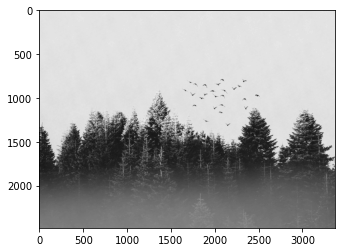

In [102]:
print(noise)
plt.imshow(noise, cmap='gray')